<a href="https://colab.research.google.com/github/DiaaEssam/Convolution_model_Step_by_Step/blob/main/LR_Optimizers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import mnist
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
tf.test.gpu_device_name()
np.seterr(over='ignore')

{'divide': 'warn', 'over': 'ignore', 'under': 'ignore', 'invalid': 'warn'}

# Loading MNIST Dataset

In [ ]:
(X_train, y_train), (X_val, y_test) = mnist.load_data()

# Subsetting The Data to The Classes 0 and 1 

In [ ]:
# Storing indeces of class 0 and class 1
idx_train_0 = np.where(y_train == 0)[0]
idx_train_1 = np.where(y_train == 1)[0]
idX_val_0 = np.where(y_test == 0)[0]
idX_val_1 = np.where(y_test == 1)[0]

# Concatenating the classes for train and test for each variable
X_train = np.concatenate((X_train[idx_train_0], X_train[idx_train_1]), axis=0)
y_train = np.concatenate((y_train[idx_train_0], y_train[idx_train_1]), axis=0)
X_val = np.concatenate((X_val[idX_val_0], X_val[idX_val_1]), axis=0)
y_test = np.concatenate((y_test[idX_val_0], y_test[idX_val_1]), axis=0)

# Visualizing some of The Data

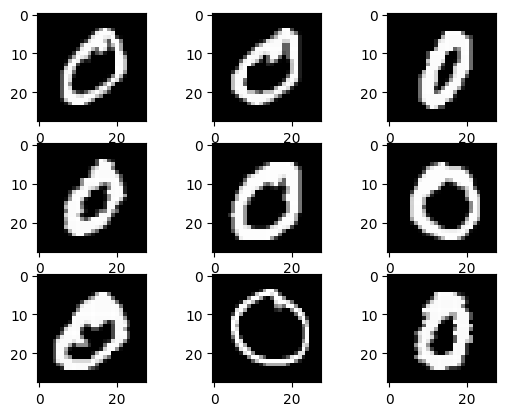

In [ ]:
for i in range(9):  
  plt.subplot(330 + 1 + i)
  plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.show()

# Transforming The Dimensions

In [ ]:
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

X_train=X_train.reshape(X_train.shape[0],-1)
X_val=X_val.reshape(X_val.shape[0],-1)
print(X_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_val:  '  + str(X_val.shape))
print('Y_test:  '  + str(y_test.shape))

X_train: (12665, 784)
Y_train: (12665,)
X_val:  (2115, 784)
Y_test:  (2115,)


# Standardizing The Data

In [ ]:
"""
Standardizing both the training set and test set using the mean and standard deviation of the training set,
This is because it ensures that the test set is processed in the same way as the training set,
and that the model's performance is evaluated on data that it has not seen before, without any information from the test set leaking into the training set.
see the following link: https://stats.stackexchange.com/questions/202287/why-standardization-of-the-testing-set-has-to-be-performed-with-the-mean-and-sd
"""
def standardize(X,X_train):
  return (X-np.mean(X_train,axis=0))/(np.std(X_train,axis=0) + 10e-16) # we need epsilon for feature (pixel) that has zero variance
  

In [ ]:
X_train=standardize(X_train,X_train)
X_val=standardize(X_val,X_val)
#X_val=standardize(X_val,X_train) # correct way

# Shuffle Function

In [ ]:
def Shuffle(X,y):
  # Storing indeces of data
  indices = np.arange(X.shape[0])
  # Shuffling the indeces
  np.random.shuffle(indices)
  # update the data and target with the new shuffled indeces
  X = X[indices]
  y = y[indices]
  return X,y

# Accuracy Function

In [ ]:
def Accuracy(y_pred,y_test):

    Acc=(np.sum(y_pred==y_test)/len(y_test)) * 100
    return round(Acc,1)

# Error Function

In [ ]:
def Error(y_pred,y_test,W,Lambda,reg):
  Cost = (np.sum((y_test * np.log(y_pred+1e-10) + (1-y_test) * np.log(1-y_pred+1e-10))) * -1/len(y_test))
  return  Cost + ((Lambda * np.sum(np.abs(W)))/ (2 * len(y_test))) if reg else Cost

# Sigmoid Function

In [ ]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

# Model

In [ ]:
def model(W,b,X):
  return np.dot(W,X.T) + b

# Net input and Error

In [ ]:
def Net_and_Error(W,b,X,y,Lambda,reg):
  yhat= model(W,b,X)
  Z=sigmoid(yhat)
  error= Error(Z,y,W,Lambda,reg)
  return Z,error

# Gradient

In [ ]:
def Gradient(Z,y,X):
  return np.mean((Z-y) * X.T),np.mean(Z-y)

#Get W_b Function

In [ ]:
def batch_method(X,y,W,b,error,Lambda,eta,reg):
        Z,error=Net_and_Error(W,b,X,y,Lambda,reg)

        """
        as the derivative of |X| is |X|/X is not defined at X=0 then we could use a trick which is the sign() function in numpy,
        and this trick is called the subdifferential 
        sign(x) = 1 if x > 0
                = 0 if x = 0
                = -1 if x < 0
        """
        dw,db=Gradient(Z,y,X)
        W= W - eta * (dw) + ((Lambda / ( 2 * len(y) )) * np.sign(W)) if reg else W -( eta * dw)
        b= b- eta * db
        return W,b,error

# Initializing RMS parameters

In [ ]:
def Initialize_RMS(beta,epsilon,Vdw,vdb):
  return beta,epsilon,Vdw,vdb

#Initializing Adam parameters

In [ ]:
def Initialize_Adam(beta1,beta2,epsilon,Vdw,Sdw,Vdb,Sdb):
  return beta1,beta2,epsilon,Vdw,Sdw,Vdb,Sdb

# RMS Function

In [ ]:
def RMS(beta,epsilon,t,W,b,dw,db,VdW,Vdb,eta):
  """
  -The RMSProp (Root Mean Square Propagation)
  -The RMSProp optimizer works by maintaining a moving average of the squared gradient for each weight
  -The RMSProp optimizer uses a decay rate/beta hyperparameter to control the weighting of past and current gradients.
  -This decay rate determines how much weight is given to the most recent gradient compared to the historical gradients.
  -A larger decay rate means that the moving average will be more heavily influenced by the historical gradients,
  -while a smaller decay rate means that the moving average will be more influenced by the most recent gradient.  
  """

  """
  -Vdw is the moving average of the squared gradients of the weights, and Vdb is the moving average of the squared gradients of the biases. 
  -These moving averages are used to adjust the learning rate during training, with the goal of improving the convergence of the optimization algorithm.
  """

  """
  -The letter "V" in Vdw and Vdb stands for "variance". In the context of the RMSProp optimizer, Vdw and Vdb represent the variance of the gradients of the weights and biases, respectively.
  -The use of variance in the RMSProp optimizer is based on the intuition that the variance of the gradients can provide information about the scale of the gradients.
  -If the variance of the gradients is high, it suggests that the gradients are large and the learning rate should be reduced to prevent overshooting the minimum. Conversely, 
  -if the variance of the gradients is low, it suggests that the gradients are small and the learning rate can be increased to speed up convergence.
  """
  VdW = ((beta * VdW) + ((1 - beta) * (dw**2))) / (1 - beta**t + epsilon)
  Vdb = ((beta * Vdb) + ((1 - beta) * (db**2))) / (1 - beta**t + epsilon)
  W = W - (eta * (dw/(np.sqrt(VdW) + epsilon)))
  b = b - (eta * (db/np.sqrt(Vdb) + epsilon))
  return W,b


#Adam Functon

In [ ]:
def Adam(beta1,beta2,t,epsilon,W,b,dw,db,VdW,SdW,Vdb,Sdb,eta):
  """
  -The Adam (Adaptive Moment Estimation) optimizer is a popular optimization algorithm used in deep learning.
  -It is an adaptive learning rate optimization algorithm that combines the benefits of two other optimization algorithms, RMSProp and momentum.
  """

  """
  -The Adam optimizer works by maintaining a moving average of the gradients and the squared gradients of the weights
  -VdW = beta1 * VdW + (1 - beta1) * dL/dw
  -SdW = beta2 * SdW + (1 - beta2) * (dL/dw)^2
  -VdW_corrected = VdW_corrected / (1 - beta1^t)
  -SdW_corrected = SdW_corrected / (1 - beta2^t)
  -w = w - alpha * VdW_corrected / (sqrt(SdW_corrected) + epsilon)
  -the same for b
  """

  """
  -beta1 and beta2 are hyperparameters
  Set β1=0, means that ADAM behaves exactly as RMSprop optimizer
  Set β2=0, means that ADAM behaves exactly as Momentum optimizer
  """
  VdW= (beta1 * VdW) + ((1 - beta1) * dw)    # Momentum
  Vdb= (beta1 * Vdb) + ((1 - beta1) * db)    # Momentum
  SdW= (beta2 * SdW) + ((1 - beta2) * dw**2) # RMS, represents variance that will be square rooted soon 
  Sdb= (beta2 * Sdb) + ((1 - beta2) * db**2) # RMS, represents variance that will be square rooted soon 
  """
  -The bias correction step helps to ensure that the moving averages are unbiased estimates of the true first and second moments of the gradients.
  -Without the bias correction step, the moving averages would be biased towards zero, which could lead to slower convergence or suboptimal performance.
  """
  VdW_corrected= VdW/(1 - beta1**t + epsilon) # bias correction
  Vdb_corrected= Vdb/(1 - beta1**t + epsilon) # bias correction
  SdW_corrected= SdW/(1 - beta2**t + epsilon) # bias correction
  Sdb_corrected= Sdb/(1 - beta2**t + epsilon) # bias correction

  W = W - eta * (VdW_corrected/np.sqrt(SdW_corrected + epsilon)) # SdW_corrected is standard deviation here
  b = b - eta * (Vdb_corrected/np.sqrt(Sdb_corrected + epsilon)) # SdW_corrected is standard deviation here
  return W,b

# Logistic_Regression_Model

In [ ]:
def Logistic_Regression(X,y,epochs,Lambda,eta,reg,batch,batch_size,rms,adam):
    W=np.random.randn(X.shape[1])
    b=np.random.randn()
    error=0

    for j in range(epochs):
        num_batches=int(X.shape[0]/batch_size)
        X,y=Shuffle(X,y)
        for i in range(num_batches):
          if batch:  
              if i != num_batches-1:        
                  W,b,error=batch_method(X[i*batch_size:batch_size*(i+1)],y[i*batch_size:batch_size*(i+1)],W,b,error,Lambda,eta,reg)
              else:
                  W,b,error=batch_method(X[i*batch_size:batch_size*(i+1) + X.shape[0] % batch_size],y[i*batch_size:batch_size*(i+1) + X.shape[0] % batch_size],W,b,error,Lambda,eta,reg)
          if rms:
              beta,epsilon,Vdw,Vdb = Initialize_RMS(0.9,10e-16,np.zeros(W.shape),0)
              Z,error=Net_and_Error(W,b,X[i*batch_size:batch_size*(i+1)],y[i*batch_size:batch_size*(i+1)],Lambda,reg) if i!=num_batches-1 else Net_and_Error(W,b,X[i*batch_size:batch_size*(i+1) + X.shape[0] % batch_size],y[i*batch_size:batch_size*(i+1) + X.shape[0] % batch_size],Lambda,reg)
              dw,db=Gradient(Z,y[i*batch_size:batch_size*(i+1)],X[i*batch_size:batch_size*(i+1)]) if i!=num_batches-1 else Gradient(Z,y[i*batch_size:batch_size*(i+1) + X.shape[0] % batch_size],X[i*batch_size:batch_size*(i+1) + X.shape[0] % batch_size])
              W,b=RMS(beta,epsilon,j,W,b,dw,db,Vdw,Vdb,eta)

          if adam:
              beta1,beta2,epsilon,VdW,SdW,Vdb,Sdb = Initialize_Adam(0.9,0.999,10e-16,np.zeros(W.shape),np.zeros(W.shape),0,0)
              Z,error=Net_and_Error(W,b,X[i*batch_size:batch_size*(i+1)],y[i*batch_size:batch_size*(i+1)],Lambda,reg) if i!=num_batches-1 else Net_and_Error(W,b,X[i*batch_size:batch_size*(i+1) + X.shape[0] % batch_size],y[i*batch_size:batch_size*(i+1) + X.shape[0] % batch_size],Lambda,reg)
              dw,db=Gradient(Z,y[i*batch_size:batch_size*(i+1)],X[i*batch_size:batch_size*(i+1)]) if i!=num_batches-1 else Gradient(Z,y[i*batch_size:batch_size*(i+1) + X.shape[0] % batch_size],X[i*batch_size:batch_size*(i+1) + X.shape[0] % batch_size])
              W,b=Adam(beta1,beta2,j,epsilon,W,b,dw,db,VdW,SdW,Vdb,Sdb,eta)
        

    print("Training_Error: ",error)
    return W,b

# Test_model Function

In [ ]:
# function to test on each model
def test_model(W,b,X_val,y_test):
    y_pred= np.dot(W,X_val.T) + b
    Z=sigmoid(y_pred)
    Z[Z>0.5]= 1
    Z[Z<0.5]= 0
    return Accuracy(Z.astype(np.int32),y_test)

In [ ]:
def Logistic_Regression_GD(X_train,y_train,X_val,y_test,epochs,Lambda=0.0,eta=0.001,reg=False,batch=False,batch_size=X_train.shape[0],rms=False,adam=False):
  W,b=Logistic_Regression(X_train,y_train,epochs,Lambda,eta,reg,batch,batch_size,rms,adam)
  Acc=test_model(W,b,X_val,y_test)
  return Acc


##Note that we will fix number of epochs to be 25 and learning rate value to be 0.001 for all cases discussed in this notebook, so we can compare fairly as possible as we could.

# Training & Testing GD with L1 Regularization/Lasso

In [ ]:
Accs={Lambda:Logistic_Regression_GD(X_train,y_train,X_val,y_test,25,Lambda,0.001,reg=True,batch=True) for Lambda in [0.01,0.1]}
print("Testing_Accuracies: ",Accs)

Training_Error:  8.180588840313005
Training_Error:  2.5856888324730427
Testing_Accuracies:  {0.01: 29.1, 0.1: 78.2}


In GD with Lasso:

It deals with high-dimensional data, as it can help in reducing the number of features by shrinking the coefficients of less important features to zero.

Is we can see, using 0.01 lambda gives us 29.1 accuracy and by increasing lambda to be 0.1 the accuracy goes up more than the one using 0.01 lambda.

We could conclude from that the more we increase lambda the more accuracy we get.

However using high lambda could affect the model badly as it will neglect many features that may be important thus making the model so simple that may not fit the training data well which makes the model do poorly on the testting data

######For good accuracies try epochs=500,eta=0.1

In [ ]:
Accs={Lambda:Logistic_Regression_GD(X_train,y_train,X_val,y_test,500,Lambda,0.1,reg=True,batch=True) for Lambda in [0.01,0.1]}
print("Testing_Accuracies: ",Accs)

Training_Error:  2.251709707724267
Training_Error:  0.9791902190842146
Testing_Accuracies:  {0.01: 83.7, 0.1: 91.3}


# Training & Testing Mini Batch GD

In [ ]:
Accs={batch_size:Logistic_Regression_GD(X_train,y_train,X_val,y_test,25,eta=0.001,batch_size=batch_size,batch=True) for batch_size in [32,64,128,256]} # For good accuracies try epochs=500,eta=0.1
print("Testing_Accuracies: ",Accs)

Training_Error:  1.77070426260131
Training_Error:  2.3767884872176066
Training_Error:  2.7881676072267823
Training_Error:  1.7562613967234644
Testing_Accuracies:  {32: 91.8, 64: 79.3, 128: 75.8, 256: 81.8}


In Mini-Batch GD:

It is faster than GD as it updates the model parameters more frequently. It can also help in avoiding local minima by introducing more randomness into the optimization process.

It has more variability in steps towards the global minimum than GD which could be the reason why it avoids local minimum that the previous models using GD with Lasso could not avoid thus gave lower accuracies than the accuracies we got using MIni batch GD.

As we can see, we used values for batch size such as 32,64,128,256, the reason we used those because they are powers of 2. Using powers of 2 can be beneficial for hardware optimization, as many computer architectures have optimized memory access patterns for powers of 2. This can lead to faster computation times and better memory utilization.

Also we can see values of 32 and 256 batch sizes give the highest accuracies.


######For good accuracies try epochs=500,eta=0.1

In [ ]:
Accs={batch_size:Logistic_Regression_GD(X_train,y_train,X_val,y_test,500,eta=0.1,batch_size=batch_size,batch=True) for batch_size in [32,64,128,256]} # For good accuracies try epochs=500,eta=0.1
print("Testing_Accuracies: ",Accs)

Training_Error:  1.479069124339658
Training_Error:  1.966076466784516
Training_Error:  1.7510401476168862
Training_Error:  1.4688943792078875
Testing_Accuracies:  {32: 88.8, 64: 86.7, 128: 87.2, 256: 87.1}


#Training & Testing Using RMS prop

In [ ]:
Accs=Logistic_Regression_GD(X_train,y_train,X_val,y_test,25,eta=0.001,batch_size=64,rms=True) 
print("Testing_Accuracies: ",Accs)

Training_Error:  1.8966207035133407
Testing_Accuracies:  85.3


In RMSProp:

Note that we used Decay Rate/Beta of 0.9.

As we can we see, we got higher accuracy using RMSProp.

It can help in avoiding the vanishing or exploding gradient problem by adjusting the learning rate based on the magnitude of the gradients.

So we could conclude that it makes the steps taken to reach to the global minimum more smoothly than Mini batch GD by adjusting the learing rate depending on 90% of historical gradients and 10% of current gradient which in fact decreases the variability of the movements towards the global minimum thus solving the probelm of high variability in Mini batch GD.

#Training & Testing Using Adam

In [ ]:
Accs=Logistic_Regression_GD(X_train,y_train,X_val,y_test,25,eta=0.001,batch_size=64,adam=True)
print("Testing_Accuracies: ",Accs)

Training_Error:  1.3320740206461432
Testing_Accuracies:  93.0


In Adam:

As we can see we got higher accuracy using Adam than Using RMSProp.

It uses the mentioned properties of RMSProp,but it adds the idea of momentum.

Using momentum allows it to use a running average of the previous updates, it can help in avoiding the problem of getting stuck in local minima and can accelerate the convergence of the optimization process.

So it has the the advantage of Mini batch GD and the advantage of RMSProp.

Also it applys Bias Correction, This can help in improving the accuracy of the optimization process and can lead to better performance.




